# Inspecting `chimestack` files and plotting visibilities

In [1]:
# %load_ext autoreload
# %autoreload 2

import os
import sys
from glob import glob

import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
%matplotlib inline

import h5py

from drift.core import manager, beamtransfer
from draco.core import containers
from drift.core.visibility import fringe, horizon
from cora.util import hputil
import ch_ephem
from ch_ephem.observers import chime
from ch_util.andata import CorrData
import caput

In [2]:
# Define alias to convert Unix timestamps to RA, using CHIME observer
unix_to_lsa = chime.unix_to_lsa

In [3]:
# Get default matplotlib color cycle, so that we can repeat colors easily in plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Set reasonable font sizes for plots
plt.rc("font", **{"size": "10"})#, "family": "serif", "serif": ["CMU serif"]})
plt.rcParams.update({'figure.figsize': (10, 7)})

In [4]:
# Load CHIME telescope class
chime_bt_config = "/project/rpp-chime/chime/bt_empty/chime_4cyl_allfreq/config.yaml"
chime_telescope = manager.ProductManager.from_config(chime_bt_config).telescope

## Get list of chimestack files for given CSD

In [5]:
# Pick an example CSD to examine
csd = 1878

In [6]:
# Query the database for the list of chimestack files containing observations
# for that CSD
from caput.pipeline import Manager, Output
from ch_pipeline.core.dataquery import QueryDatabase

m = Manager()
query = QueryDatabase()
query.start_csd = csd
query.end_csd = csd+1
query.accept_all_global_flags = True
query.node_spoof['cedar_online'] = "/project/rpp-chime/chime/chime_online/"
query.instrument = "chimestack"
m.add_task(query, out="filelist")
out_task = Output()
m.add_task(out_task, in_="filelist")
m.run()

chimestack_list = out_task.outputs[0]

In [7]:
print(chimestack_list)

['/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00951743_0000.h5', '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00956832_0000.h5', '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00961922_0000.h5', '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00967011_0000.h5', '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00972101_0000.h5', '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00977190_0000.h5', '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00982280_0000.h5', '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00987370_0000.h5', '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00992459_0000.h5', '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00997549_0000.h5', '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/01002638_0000.h5'

## Inspect a chimestack file

In [8]:
# Get filename of example chimestack file (chosen to contain Tau A)
chimestack_example_file = chimestack_list[4]

In [9]:
# Look at contents of file
with h5py.File(chimestack_example_file, "r") as f:
    print("Datasets in file:")
    print('\t', f.keys())

    print("Axes in index_map:")
    print('\t', f['index_map'].keys())

Datasets in file:
	 <KeysViewHDF5 ['flags', 'gain', 'index_map', 'reverse_map', 'vis']>
Axes in index_map:
	 <KeysViewHDF5 ['freq', 'input', 'prod', 'stack', 'time']>


In [10]:
# Look at vis dataset of file
with h5py.File(chimestack_example_file, "r") as f:
    print(f"Shape of vis dataset: ")
    print('\t', f['vis'].shape)
    print(f"Axes of vis dataset: ")
    print('\t', f['vis'].attrs['axis'])

Shape of vis dataset: 
	 (1024, 16356, 512)
Axes of vis dataset: 
	 ['freq' 'stack' 'time']


In [11]:
# Look at each axis
with h5py.File(chimestack_example_file, "r") as f:
    for axis in f['index_map'].keys():
        print(f"Shape of {axis} axis: ")
        print('\t', f[f'index_map/{axis}'].shape)
        print(f"dtype of {axis} axis:")
        print('\t',  f[f'index_map/{axis}'].dtype)
        print(f"Example slice of {axis} axis:")
        print(f[f'index_map/{axis}'][:5])
        print()

Shape of freq axis: 
	 (1024,)
dtype of freq axis:
	 [('centre', '<f8'), ('width', '<f8')]
Example slice of freq axis:
[(800.      , 0.390625) (799.609375, 0.390625) (799.21875 , 0.390625)
 (798.828125, 0.390625) (798.4375  , 0.390625)]

Shape of input axis: 
	 (2048,)
dtype of input axis:
	 [('chan_id', '<u2'), ('correlator_input', 'S32')]
Example slice of input axis:
[(0, b'FCC000812') (1, b'FCC000813') (2, b'FCC000814') (3, b'FCC000815')
 (4, b'FCC000808')]

Shape of prod axis: 
	 (2098176,)
dtype of prod axis:
	 [('input_a', '<u2'), ('input_b', '<u2')]
Example slice of prod axis:
[(0, 0) (0, 1) (0, 2) (0, 3) (0, 4)]

Shape of stack axis: 
	 (16356,)
dtype of stack axis:
	 {'names': ['prod', 'conjugate'], 'formats': ['<u4', 'u1'], 'offsets': [0, 4], 'itemsize': 8}
Example slice of stack axis:
[(491648, 0) (491649, 0) (491650, 0) (491651, 0) (491652, 0)]

Shape of time axis: 
	 (512,)
dtype of time axis:
	 [('fpga_count', '<u8'), ('ctime', '<f8')]
Example slice of time axis:
[(380348

The axes in the file's `index_map` are as follows:
- `freq`: centres and widths of each frequency channel
- `input`: identities of each ADC input (feed: antenna+polarization). An ADC input is described by a unique integer determined by its location in the FPGA rack known as the channel ID.
- `prod`: all pairs of feeds that were correlated by the correlator, as `chan_id` of each input in a visibility. If the file contains visibilities that have been averaged ("stacked") over redundant baselines, the `prod` axis will be much larger than the number of visibilities in the file.
- `stack`: exists in files containing stacked visibilities. The length of this axis corresponds to the number of visibilities stored in the file. The `prod` item in each element is the index of *one* element of the `prod` axis that went into the average (this is sufficient to figure out the baseline vector and polarizations corresponding to this visibility). The `conjugate` item denotes whether the complex conjugate of the visibility has been stored.
- `time`: Unix timestamps for each integration. From doclib:5, `fpga_count` is "number of flag trips coming from the FPGA".

In [12]:
def prodstack(filename):
    """Pair of input indices representative of those in the stack.

    Note, these are correctly conjugated on return, and so calculations
    of the baseline and polarisation can be done without additionally
    looking up the stack conjugation.

    Adapted from ch_util.andata.CorrData.
    """
    with h5py.File(filename, "r") as f:
        # If file hasn't been "stacked" over redundant baselines, just
        # return the prod axis, since every feed/pol pair exists in the
        # file
        if "stack" in f["index_map"].keys():
            if len(f["index_map/stack"]) == len(f["index_map/prod"]):
                return f["index_map/prod"][:]
        else:
            return f["index_map/prod"][:]

        # Fetch representative elements of prod index for each element
        # of stack index
        t = f["index_map/prod"][:][f["index_map/stack"]["prod"]]

        # Swap inputs for visibilities that have been complex-conjugated
        # prior to storage
        prodmap = t.copy()
        conj = f["index_map/stack"]["conjugate"]
        prodmap["input_a"] = np.where(conj, t["input_b"], t["input_a"])
        prodmap["input_b"] = np.where(conj, t["input_a"], t["input_b"])

    return prodmap

In [13]:
# Compute prodstack for example file
example_prodstack = prodstack(chimestack_example_file)

In [14]:
# Compute feed positions for each element in prodstack, and use to compute
# array of baselines
feedpos_a = chime_telescope.feedpositions[example_prodstack['input_a']]
feedpos_b = chime_telescope.feedpositions[example_prodstack['input_b']]
b_array = feedpos_b - feedpos_a

# Fetch polarization (X or Y) of each input in a given visibility
pol_a = chime_telescope.polarisation[example_prodstack['input_a']]
pol_b = chime_telescope.polarisation[example_prodstack['input_b']]

## Plot whole set of visibilities at specific frequency

In [15]:
# Select a frequency index to plot
freq_i = 256

Text(0.5, 1.0, '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00972101_0000.h5, 700.0 MHz')

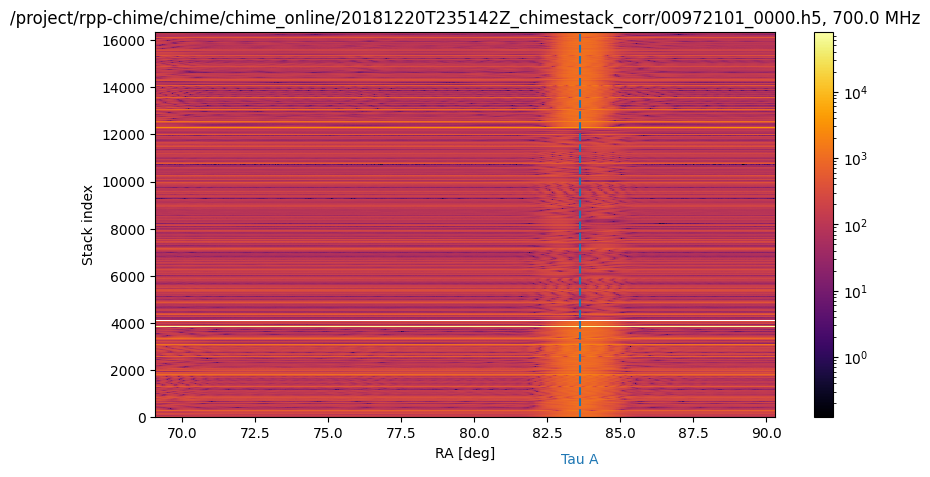

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Get subset of visibilities, time axis, and subset of stack axis from file
with h5py.File(chimestack_example_file, "r") as f:
    vis_for_plot = f['vis'][freq_i]
    times = f['index_map/time']['ctime']
    stack_axis = f['index_map/stack'][:]
    freq = f['index_map/freq']['centre'][freq_i]

# Convert timestamps to RA coordinates transiting local meridian at each
# timestamp
ra = unix_to_lsa(times)

# Get coords of Tau A, which we expect to appear in this plot
tauA_ra, tauA_dec = ch_ephem.coord.object_coords(ch_ephem.sources.TauA, deg=True)

# Plot log-scale heatmap of absolute value of visibilities
im = ax.imshow(
    np.abs(vis_for_plot), 
    origin='lower', 
    interpolation='none', 
    aspect='auto', 
    norm=LogNorm(),
    extent=(ra[0], ra[-1],0, len(stack_axis)),
    cmap='inferno'
)
plt.colorbar(im)

# Plot vertical line at RA of Tau A
ax.axvline(tauA_ra, ls='--', c=colors[0])
ax.text(tauA_ra, -2000, "Tau A", horizontalalignment='center', c=colors[0])

ax.set_xlabel("RA [deg]")
ax.set_ylabel("Stack index")
plt.title(f"{chimestack_example_file}, {freq} MHz")

## Example of plotting a specific subset of baselines/polarizations

In [17]:
# Let's select baselines with a specific x coordinate for each input
# (within some tolerance) and also a specific polarization for each
# input.
x_a = -33
dx_a = 0.2
x_b = -33
dx_b = 0.2
p_a = "X"
p_b = "X"

# Make masks to select for these x coordinates and polarizations
b_mask = (np.abs(feedpos_a[:, 0] - x_a) < dx_a) & (np.abs(feedpos_b[:, 0] - x_b) < dx_b)
p_mask = (pol_a == p_a) & (pol_b == p_b)

# Combined mask
bp_mask = b_mask & p_mask

# Finally, select a frequency index to plot
freq_i = 256

Text(0.5, 1.0, '/project/rpp-chime/chime/chime_online/20181220T235142Z_chimestack_corr/00972101_0000.h5, XX, Cyl A intracyl, 700.0 MHz')

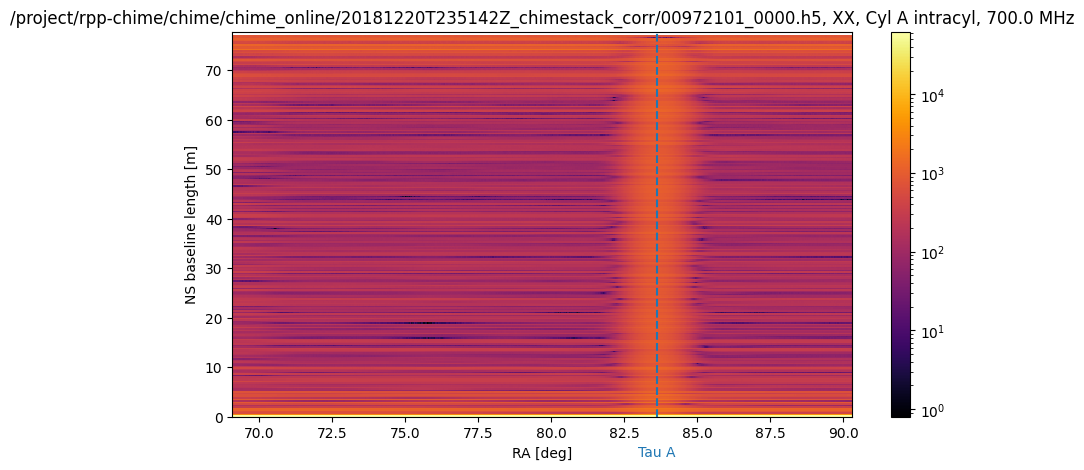

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Get subset of visibilities, time axis, and subset of stack axis from file
with h5py.File(chimestack_example_file, "r") as f:
    vis_for_plot = f['vis'][freq_i, bp_mask]
    times = f['index_map/time']['ctime']
    stack_axis = f['index_map/stack'][bp_mask]
    freq = f['index_map/freq']['centre'][freq_i]

# Convert timestamps to RA coordinates transiting local meridian at each
# timestamp
ra = unix_to_lsa(times)

# Get subset of baseline vectors we selected, and sort by NS baseline
# length
b_array_sub = b_array[bp_mask]
b_sort_idx = np.argsort(b_array_sub[:, 1])

# Get coords of Tau A, which we expect to appear in this plot
tauA_ra, tauA_dec = ch_ephem.coord.object_coords(ch_ephem.sources.TauA, deg=True)

# Plot log-scale heatmap of absolute value of visibilities
im = ax.imshow(
    np.abs(vis_for_plot)[b_sort_idx], 
    origin='lower', 
    interpolation='none', 
    aspect='auto', 
    norm=LogNorm(),
    extent=(ra[0], ra[-1], b_array_sub[b_sort_idx][0, 1], b_array_sub[b_sort_idx][-1, 1]),
    cmap='inferno'
)
plt.colorbar(im)

# Plot vertical line at RA of Tau A
ax.axvline(tauA_ra, ls='--', c=colors[0])
ax.text(tauA_ra, -8, "Tau A", horizontalalignment='center', c=colors[0])

ax.set_xlabel("RA [deg]")
ax.set_ylabel("NS baseline length [m]")
plt.title(f"{chimestack_example_file}, XX, Cyl A intracyl, {freq} MHz")